In [50]:
import pandas as pd
import matplotlib.pyplot as plt

harrisP1 = pd.read_csv("data/HarrisPartI.csv")
harrisP3 = pd.read_csv("data/HarrisPartIII.csv")
Krause = pd.read_csv("data/Krause21.csv")
VandenBerg = pd.read_csv("data/vandenBerg_table2.csv")

def norm_ids(series):
    return series.dropna().astype(str).str.replace(r"\s+","",regex=True).str.upper()

kraus_ids=set(norm_ids(Krause["Object"]))
VandenBerg_ids=set('NGC'+norm_ids(VandenBerg["#NGC"]))

VandenBerg.iloc[:,0] = "NGC" + VandenBerg.iloc[:,0].astype(str)
#print(VandenBerg.iloc[:,0] )
#print(Krause.iloc[:,1] )

union_ids = kraus_ids | VandenBerg_ids
uncommon_ids = kraus_ids ^ VandenBerg_ids
#print (len(union_ids))
#print(union_ids)

list_accreted = ['Arp2' ,'NGC5024' ,'Crater' ,'IC4499', 'Pal4' ,'NGC5694' ,'NGC2298', 'NGC4147',
 'Pal14' ,'NGC7089' ,'NGC5272', 'NGC6934', 'NGC6101', 'NGC5466', 'Pal5' ,'Pal15',
 'Pal13' ,'NGC5053', 'NGC6715', 'Pal2', 'NGC1261', 'Whiting1' ,'NGC5634',
 'NGC7492', 'Terzan7', 'NGC5904' ,'IC1257', 'NGC2419' ,'NGC7006' ,'NGC6584',
 'NGC3201' ,'NGC6229' ,'Pyxis', 'NGC1904', 'NGC1851', 'Terzan8', 'NGC6981' ,'E1',
 'NGC6864', 'Eridanus' ,'AM4', 'FSR1758']
set_accreted = set(list_accreted)

int_accreted = set_accreted & union_ids
print(uncommon_ids&int_accreted)
#print(set_accreted)
#print(union_ids)
#print(int_accreted)
#print(len(int_accreted))

Krause_filtered = Krause[Krause["Object"].isin(int_accreted)]
VandenBerg_filtered = VandenBerg[VandenBerg["#NGC"].isin(int_accreted)]

VandenBerg_filtered= VandenBerg_filtered.rename(columns={"#NGC":"ID"})

union_GCs= pd.concat([Krause_filtered, VandenBerg_filtered], ignore_index=True)

#print(union_GCs)

{'NGC1904', 'NGC4147', 'NGC2298'}


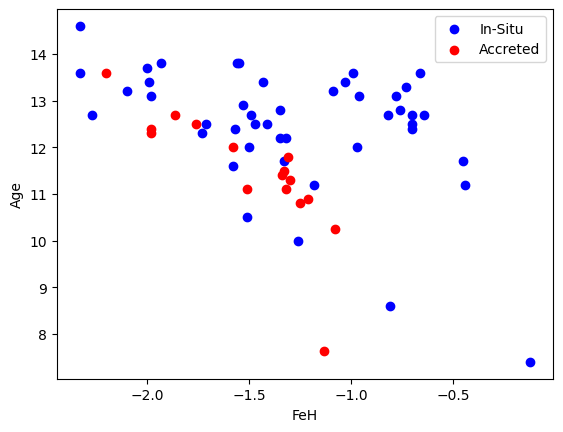

In [41]:
# Create a mask for IDs in int_accreted
mask = Krause['Object'].isin(int_accreted)

# Create the figure and axis
fig, ax = plt.subplots()

# Plot non-accreted stars (blue)
ax.scatter(Krause.loc[~mask, 'FeH'], Krause.loc[~mask, 'Age'], color='blue', label='In-Situ')

# Plot accreted stars (red)
ax.scatter(Krause.loc[mask, 'FeH'], Krause.loc[mask, 'Age'], color='red', label='Accreted')

# Add labels and legend
ax.set_xlabel('FeH')
ax.set_ylabel('Age')
ax.legend()

plt.show()


#Krause.plot(kind = 'scatter', x ='FeH',y='Age')

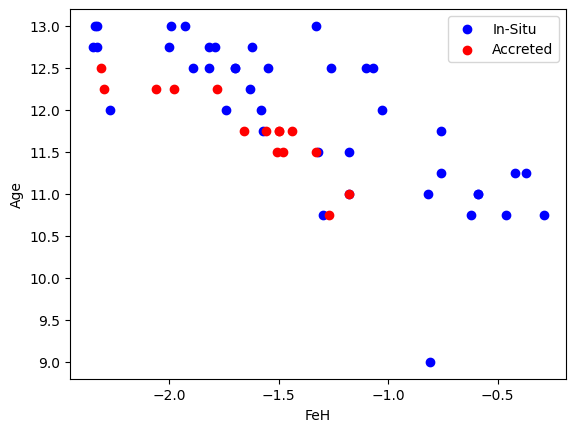

In [45]:
# Create a mask for IDs in int_accreted
mask = VandenBerg['#NGC'].isin(int_accreted)

# Create the figure and axis
fig, ax = plt.subplots()

# Plot non-accreted stars (blue)
ax.scatter(VandenBerg.loc[~mask, 'FeH'], VandenBerg.loc[~mask, 'Age'], color='blue', label='In-Situ')

# Plot accreted stars (red)
ax.scatter(VandenBerg.loc[mask, 'FeH'], VandenBerg.loc[mask, 'Age'], color='red', label='Accreted')

# Add labels and legend
ax.set_xlabel('FeH')
ax.set_ylabel('Age')
ax.legend()


#VandenBerg.plot(kind = 'scatter', x ='FeH',y='Age')